In [28]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

import numpy as np
import pandas as pd

from Bio.PDB import PDBParser, PDBIO

from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import protfasta
from pymol import cmd, stored, math
import random

# Processing

In [2]:
# # Input and output file paths
# input_file = '/content/drive/MyDrive/Staller Lab Research/Gal11Mapping/med15_KIX_filtered (1).align'
# output_file = 'converted_alignment.fasta'

# # Read the alignment from the input file
# try:
#     with open(input_file, 'r') as file:
#         lines = file.readlines()

#     sequences = []
#     current_seq_id = ""
#     current_seq = []

#     for line in lines:
#         if line.startswith('>'):
#             if current_seq_id:
#                 sequences.append(SeqRecord(Seq(''.join(current_seq)), id=current_seq_id, description=""))
#             current_seq_id = line.strip().lstrip('>')
#             current_seq = []
#         else:
#             current_seq.append(line.strip())

#     if current_seq_id:
#         sequences.append(SeqRecord(Seq(''.join(current_seq)), id=current_seq_id, description=""))

#     alignment = MultipleSeqAlignment(sequences)

#     AlignIO.write(alignment, output_file, 'fasta')

#     print(f"File converted and saved to {output_file}.")

# except Exception as e:
#     print(f"An error occurred: {e}")


In [3]:
# # Method to store fasta sequences in a string
# def read_amino_acid_sequence(file_path):
#     with open(file_path, 'r') as file:
#         next(file)
#         sequence = ''.join(line.strip() for line in file)
#     return sequence

In [4]:
# # consensus sequence
# consensus_file_path = '/content/drive/MyDrive/Staller Lab Research/Gal11Mapping/ClaireAlignmentConsensus.txt'
# consensus_sequence = read_amino_acid_sequence(consensus_file_path)

# # g002133
# g002133_file_path = '/content/drive/MyDrive/Staller Lab Research/Gal11Mapping/g002133.m1__saccharomyces_cerevisiae_1-1081.txt'
# g002133_sequence = read_amino_acid_sequence(g002133_file_path)

In [5]:
# g002133_sequence_array = list(g002133_sequence)
# consensus_sequence_array = list(consensus_sequence)

# Use from here

In [6]:
def read_fasta_file(filename):
    """
    Reads a FASTA file and returns a list of protein sequences.
    :param filename: name of the FASTA file to read
    :return: a list of protein sequences as strings
    """
    sequences = []
    with open(filename) as f:
        sequence = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if sequence:
                    sequences.append(sequence)
                    sequence = ""
            else:
                sequence += line
        if sequence:
            sequences.append(sequence)
    return sequences

def return_ref_seq(filename):
    fasta_dict = protfasta.read_fasta(filename, invalid_sequence_action = 'ignore')
    for key in fasta_dict.keys():
        if 'REFERENCE' in key:
            return fasta_dict[key]


In [7]:
filename = '../data/zoonomia_toga_mca/all_AD_alignments/CITED2_220-269.fasta'

g002133_sequence_array = list(return_ref_seq(filename))

In [8]:
return_ref_seq(filename)

'TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTDFVCKQQPSRVS'

In [9]:
# SK's Alignments here
sequences = read_fasta_file(filename)
len(sequences)

438

In [10]:
def calculate_percentage_identity(sequences):
    num_sequences = len(sequences)
    sequence_length = len(sequences[0])
    identity_array = np.zeros(sequence_length)

    for i in range(sequence_length):
        residues_at_position = [sequence[i] for sequence in sequences if sequence[i] != '-']
        if len(residues_at_position) == 0:
            identity_array[i] = 0
        else:
            most_common_residue = max(set(residues_at_position), key=residues_at_position.count)
            num_common_residues = residues_at_position.count(most_common_residue)
            percentage_identity = (num_common_residues / num_sequences) * 100
            identity_array[i] = percentage_identity

    return identity_array

In [11]:
percent_identities = calculate_percentage_identity(sequences)

In [12]:
percent_identities

array([ 99.7716895 ,  99.543379  ,  99.7716895 ,  99.543379  ,
        99.7716895 , 100.        ,  99.7716895 ,  99.7716895 ,
        99.7716895 ,  99.7716895 , 100.        , 100.        ,
       100.        ,  99.08675799, 100.        ,  99.543379  ,
        99.7716895 ,  99.7716895 , 100.        , 100.        ,
        99.7716895 , 100.        , 100.        , 100.        ,
       100.        ,  99.7716895 ,  99.7716895 , 100.        ,
       100.        , 100.        ,  99.7716895 , 100.        ,
        99.7716895 , 100.        , 100.        , 100.        ,
        99.7716895 ,  99.543379  , 100.        , 100.        ,
       100.        ,  99.7716895 ,  99.7716895 ,  99.7716895 ,
       100.        , 100.        ,  99.7716895 , 100.        ,
       100.        , 100.        ])

In [13]:
def gal11_percent_identity_map(identity_array, msa_gal11_sequence):
    gal11_identity = []
    for i in range(len(msa_gal11_sequence)):
        if msa_gal11_sequence[i] != '-':
            gal11_identity.append(identity_array[i])
    return gal11_identity

gal11_percent_identities = gal11_percent_identity_map(percent_identities, g002133_sequence_array)

#confirms that we have a correct mapping to gal11 sequence of interest
len(gal11_percent_identities) == len(return_ref_seq(filename))


True

In [14]:
parser = PDBParser()
structure = parser.get_structure("CITED2", "../data/1r8u.pdb")

for residue, identity in zip(structure[0]["A"].get_residues(), gal11_percent_identities):
    #residue["CA"].bfactor = identity
    residue["CA"].bfactor = random.randint(1, 100)

io = PDBIO()
io.set_structure(structure)
io.save("../output/CITED2_projectedPercentIdentities.pdb")

 Ray: render time: 0.25 sec. = 14508.3 frames/hour (0.25 sec. accum.).


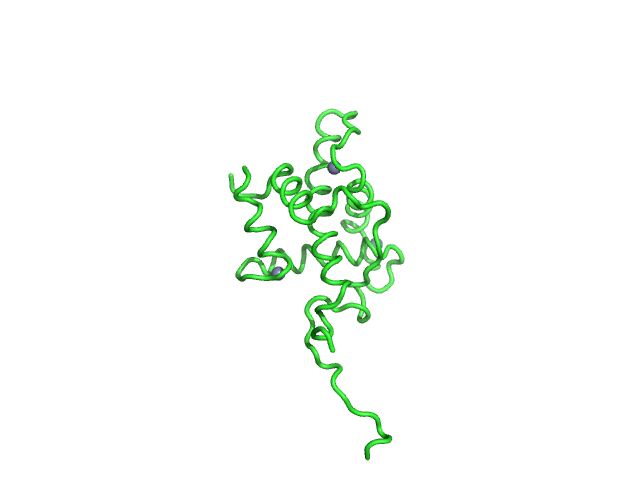

In [15]:
#cmd.fragment('gly')
#cmd.orient()
cmd.load("../output/CITED2_projectedPercentIdentities.pdb", "CITED2")
#cmd.color("blue", "CITED2")
#cmd.show("cartoon", "CITED2")
#cmd.color("spectrum", "CITED2")
cmd.ipython_image()

In [16]:
cmd.spectrum(expression="b", palette="rainbow",
             selection="(all)", 
             byres=1, quiet=1)

(0.0, 0.0)

 Ray: render time: 0.25 sec. = 14654.3 frames/hour (0.49 sec. accum.).


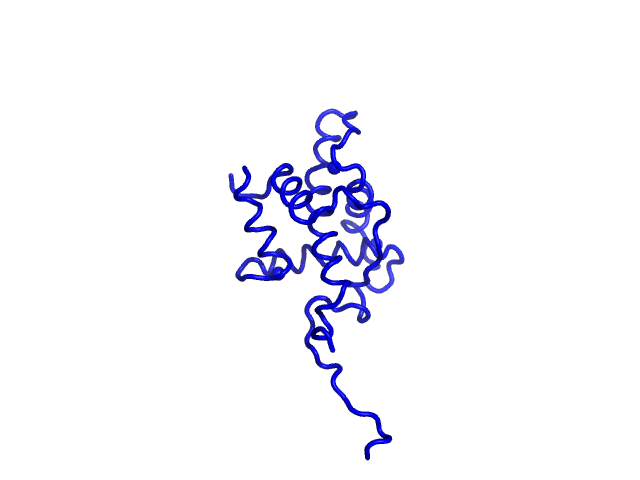

In [17]:
cmd.ipython_image()

In [18]:
cmd.iterate("all", "print(name, b)")


N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG2 0.0
OG1 0.0
HA 0.0
HB 0.0
HG1 0.0
HG21 0.0
HG22 0.0
HG23 0.0
H1 0.0
H2 0.0
H3 0.0
N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG 0.0
OD1 0.0
OD2 0.0
H 0.0
HA 0.0
HB2 0.0
HB3 0.0
N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG 0.0
CD1 0.0
CD2 0.0
CE1 0.0
CE2 0.0
CZ 0.0
H 0.0
HA 0.0
HB2 0.0
HB3 0.0
HD1 0.0
HD2 0.0
HE1 0.0
HE2 0.0
HZ 0.0
N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG1 0.0
CG2 0.0
CD1 0.0
H 0.0
HA 0.0
HB 0.0
HG12 0.0
HG13 0.0
HG21 0.0
HG22 0.0
HG23 0.0
HD11 0.0
HD12 0.0
HD13 0.0
N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG 0.0
OD1 0.0
OD2 0.0
H 0.0
HA 0.0
HB2 0.0
HB3 0.0
N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG 0.0
CD 0.0
OE1 0.0
OE2 0.0
H 0.0
HA 0.0
HB2 0.0
HB3 0.0
HG2 0.0
HG3 0.0
N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG 0.0
CD 0.0
OE1 0.0
OE2 0.0
H 0.0
HA 0.0
HB2 0.0
HB3 0.0
HG2 0.0
HG3 0.0
N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG1 0.0
CG2 0.0
H 0.0
HA 0.0
HB 0.0
HG11 0.0
HG12 0.0
HG13 0.0
HG21 0.0
HG22 0.0
HG23 0.0
N 0.0
CA 0.0
C 0.0
O 0.0
CB 0.0
CG 0.0
CD1 0.0
CD2 0.0
H 0.0
HA 0.0
HB2 0.0
HB3 0.0


2382